Chanakya Maddineni
UID: 117999655


# Introduction

In recent decades, weather patterns around the world have become increasingly and noticeably erratic. Parts of the world are hit with ever worsening floods and other regions experience intense droughts. Agriculture, being an industry inherently tied to the earth and the climate, is heavily impacted by weather patterns. It is growing ever more important to understand the impact that climate has on agriculture. 

Perhaps the most prominently affected weather phenomena by climate change are temperature and storms. Therefore, this project will focus on average yearly temperature, as well as the number of storm events and the amount of agricultural damage they cause. 

This project will look at the impact climactic conditions have on the total factor productivity index of a state. This index is a measure of the aggregate agirultural output relative to the aggregate inputs. This measure can better control for increases or decreases in crop yield that can be explained by factors outside of climate, such as the usage of better technologies or shifts in labor. 

## Data Collection

There is an abundance of data on precipitation and temperature in the contiguous continental United States. Much of this data, is in a raw form and must be cleaned. Fortunately, the Washington Post has compiled American county-wise averages of average temperature data from 1895 to 2019, as collected from the National Oceanic and Atmospheric Administration's Climate Divisional Database and made it available on their  <a href = "https://github.com/washingtonpost/data-2C-beyond-the-limit-usa">Github page</a> in the form of a csv. We will download this dataset. 


In addition to this, we will also require data on total factor productivity of each state. This data is available in excel sheets from the <a href = "https://www.ers.usda.gov/data-products/agricultural-productivity-in-the-u-s/agricultural-productivity-in-the-u-s/"> United States Department of Agriculture's tables on agricultural productivity in the United States</a>.

### Imports

After having downloaded the necesary data, we will import all of the necessary libraries and modules we will need for this project.

In [1]:
import os
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import statsmodels.formula.api as sm
import sklearn

## Data Processing

We load in the data on agricultural total factor productivity into a dataframe. Since the data is in a .xls format (an older format of Excel spreadsheets), I first converted this to a .xlsx format (a newer version of excel) by saving it as a .xlsx file. This is not necessary, as the read_csv() function works the same on both formats, but it might make it more convenient if you want to edit the spreadsheet in Microsoft Excel. 


The csv file for temperature has a column for a five digit value called the fips value. The first two digits of this value represent the state for which the reading takes place, and the last three digits represent the county. While our temperature csv file does not have columns that store the names of the states or counties, there is a second csv file that provides the average temperature change for each county. This table has columns for fips values as well as states and county names. 

Therefore, we can get the state and county names by merging these two tables together. Since the temperature change csv file contains many columns which we do not require, we can remove those and only keep the ones 

In [2]:
pathc = './Climate/'

temp = pd.read_csv(pathc + 'temp_county_year.csv')
temp = temp.drop(columns = ['tempc'])

# Reads in the temp_change CSV file
temp_change = pd.read_csv(pathc + 'temp_change.csv', encoding='latin-1')
# Removes all rows except for the fips and county and state names
temp_change = temp_change[['fips', 'CTYNAME', 'STNAME']]

# Merges the temp_change and temp
temp = temp.merge(temp_change, on = ['fips'])

# Only include years on or after 1960, since we only have agricultural productivity data for those years.
temp = temp[temp['year'] >= 1960]

display(temp.head)

<bound method NDFrame.head of          fips  year       temp         CTYNAME   STNAME
65       1001  1960  62.608333  Autauga County  Alabama
66       1001  1961  62.591667  Autauga County  Alabama
67       1001  1962  63.875000  Autauga County  Alabama
68       1001  1963  62.666667  Autauga County  Alabama
69       1001  1964  62.875000  Autauga County  Alabama
...       ...   ...        ...             ...      ...
388370  56045  2015  46.633333   Weston County  Wyoming
388371  56045  2016  47.250000   Weston County  Wyoming
388372  56045  2017  45.650000   Weston County  Wyoming
388373  56045  2018  43.725000   Weston County  Wyoming
388374  56045  2019  42.300000   Weston County  Wyoming

[186420 rows x 5 columns]>

Now we read in the dataset of agricultural total factor productivity.

In [3]:
patha = './Agriculture/'
agr = pd.read_excel(patha + 'Indices of total factor productivity by State.xlsx')
# Creates a list of the blank unnamed columns that are read in from the Excel sheet to be dropped from the dataframe.
unnamed = ["Unnamed: " + str(i) for i in range(49, 65)]
agr = agr.drop(columns = unnamed)
agr = agr.melt(id_vars = ['Year'], var_name = 'state', value_name = 'tfp')

agr = agr.drop([0,1], axis = 0)
display(agr.head)

<bound method NDFrame.head of         Year state       tfp
2     1960.0    AL  0.659890
3     1961.0    AL  0.675506
4     1962.0    AL  0.635884
5     1963.0    AL  0.707318
6     1964.0    AL  0.695243
...      ...   ...       ...
2251  2000.0    WY  0.568283
2252  2001.0    WY  0.597144
2253  2002.0    WY  0.538451
2254  2003.0    WY  0.582018
2255  2004.0    WY  0.571194

[2254 rows x 3 columns]>

Now we read in data on storm events. This data is spread over multiple csv files, one for each year, so we will have to read each csv file and append it to our main dataframe. 
We will do this by reading one csv file into a dataframe at a time, and extracting only the columns we need. These are the state, year, and crop damage columns.

In addition, as there are many, many storm entries in this dataset, we will only take the top 500 ones from each year in terms of crop damage. 

We will create a function be applied to each dataframe where this happens. 

In [4]:
def clean(df): 
    df = df[['YEAR', 'STATE', 'STATE_FIPS', 'CZ_FIPS', 'DAMAGE_CROPS']]
    
    df = df.sort_values('DAMAGE_CROPS').head(500)
    
    df['STATE_FIPS'] = df['STATE_FIPS'].astype(str)
    df['CZ_FIPS'] = df['CZ_FIPS'].astype(str)
    
    for i, row in df.iterrows():
        st = row['STATE_FIPS']
        while len(st) < 2:
            st = '0' + st
        
        cz = row['CZ_FIPS']
        while len(cz) < 3:
            cz = '0' + cz
            
        fips = st + cz
        df.loc[i, 'CZ_FIPS'] = fips     

    return df

In [5]:
warnings.filterwarnings('ignore')

paths = pathc + 'Storm/'

storms = pd.DataFrame()

for file in os.listdir(paths):
    if file.endswith(".gz"):
        df = pd.read_csv(paths + file, compression='gzip')
        df = clean(df)
    storms = pd.concat([storms, df])

storms = storms.drop('STATE_FIPS', axis = 1)
storms = storms.rename(columns = {'CZ_FIPS':'FIPS'})

display(storms.head(5))
display(storms.tail(5))

,YEAR,STATE,FIPS,DAMAGE_CROPS
0,1960,NEBRASKA,31121,0
1303,1960,SOUTH DAKOTA,46059,0
1302,1960,SOUTH DAKOTA,46055,0
1301,1960,SOUTH DAKOTA,46007,0
1300,1960,SOUTH DAKOTA,46103,0


,YEAR,STATE,FIPS,DAMAGE_CROPS
2701,2023,CALIFORNIA,06019,0.00K
2702,2023,CALIFORNIA,06019,0.00K
2703,2023,CALIFORNIA,06039,0.00K
2704,2023,CALIFORNIA,06107,0.00K
2705,2023,CALIFORNIA,06029,0.00K


## Exploratory Data Analysis and Visualization


### Visualizing trend in temperature

We will first look at the trends in temperature for the nation as a whole. 

In [7]:
temp_avg = temp[['year', 'temp']]
temp_avg = temp_avg.groupby('year', as_index = False).mean()
display(temp_avg.head(5))

,year,temp
0,1960,52.804898
1,1961,53.329455
2,1962,53.406649
3,1963,53.476810
4,1964,53.807950


Text(0, 0.5, 'Average temperature (in degrees Fahrenheit)')

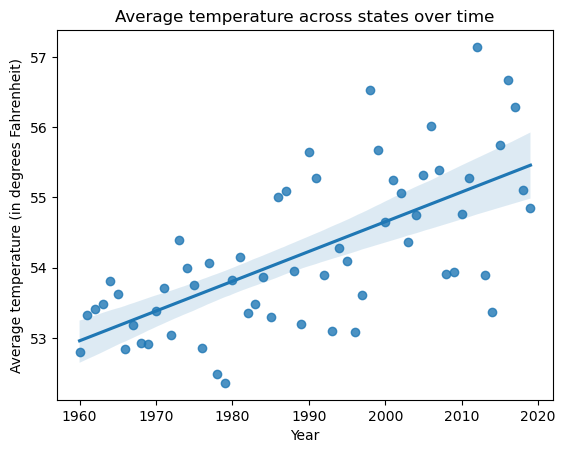

In [8]:
sns.regplot(data = temp_avg, x = 'year', y = 'temp')
plt.title("Average temperature across states over time")
plt.xlabel("Year")
plt.ylabel("Average temperature (in degrees Fahrenheit)")

From the plot, we can can see that there is an upward trend in the average temperature of the United States. 
We can also visualize the trends in agricultural TFP averaged across all the states. 

### Visualizing trend in TFP

Now we will look at how TFP has increased over time in the United States. This will be done by averaging the TFP across all states for each year and plotting them against years. 

Text(0, 0.5, 'Average TFP')

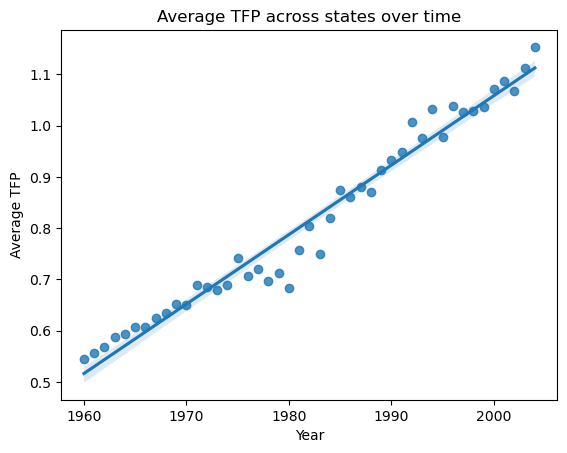

In [9]:
agr_avg = agr[['Year', 'tfp']]
agr_avg = agr.groupby('Year', as_index = False).mean('tfp')

sns.regplot(data = agr_avg, x = 'Year', y = 'tfp')
plt.title("Average TFP across states over time")
plt.xlabel("Year")
plt.ylabel("Average TFP") 

We see that average TFP across the nation increases over time, which is to be expected as farming practices become more efficient. 

### Visualizing trend in storm data

We will now get a better idea of the trends in storm data. First, we will look at how many storms hit each state over this time frame. 

In [10]:
states = np.unique(storms['STATE'])
n_storms = [0] * len(states)

state_count = pd.DataFrame(columns = ['state','num_storms'])

i = 0
# Getting the number of storms that hit each state.
for state in states:
    num_events = len(storms[storms['STATE'] == state])
    n_storms[i] = num_events
    i = i + 1

state_count['state'] = states
state_count['num_storms'] = n_storms

state_count = state_count.sort_values('num_storms', ascending = False)

display(state_count)

,state,num_storms
56,TEXAS,3668
21,KANSAS,2164
20,IOWA,2151
47,OKLAHOMA,1820
19,INDIANA,1538
...,...,...
27,LAKE ST CLAIR,5
2,AMERICAN SAMOA,2
54,ST LAWRENCE R,2
14,GUAM,1


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TEXAS'),
  Text(1, 0, 'KANSAS'),
  Text(2, 0, 'IOWA'),
  Text(3, 0, 'OKLAHOMA'),
  Text(4, 0, 'INDIANA'),
  Text(5, 0, 'ILLINOIS'),
  Text(6, 0, 'FLORIDA'),
  Text(7, 0, 'SOUTH DAKOTA'),
  Text(8, 0, 'WISCONSIN'),
  Text(9, 0, 'GEORGIA'),
  Text(10, 0, 'VIRGINIA'),
  Text(11, 0, 'NEBRASKA'),
  Text(12, 0, 'PENNSYLVANIA'),
  Text(13, 0, 'OHIO'),
  Text(14, 0, 'NORTH CAROLINA'),
  Text(15, 0, 'WYOMING'),
  Text(16, 0, 'ARKANSAS'),
  Text(17, 0, 'KENTUCKY'),
  Text(18, 0, 'TENNESSEE'),
  Text(19, 0, 'COLORADO')])

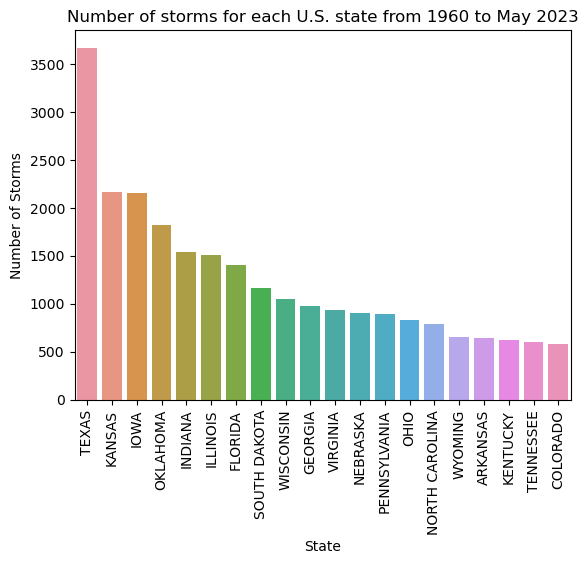

In [11]:
sns.barplot(data = state_count.head(20), x = 'state', y = 'num_storms')
plt.title("Number of storms for each U.S. state from 1960 to May 2023")
plt.xlabel("State")
plt.ylabel("Number of Storms")
plt.xticks(rotation=90)

From this, we see that it appears that Texas is the state that is most commonly hit by storms. This is followed by other states in and around the midwest, including Kansas, Iowa, Oklahoma, and Indiana. One thing to note is that these only include the top 500 storms per year by crop damage, so this is not necessarily an accurate representation how much states are hit by storms in general. However, they do give us an idea of which states have to deal with agricultural losses due to storms more than other states. 


In addition to this, another measure of which states are hit hardest by storms, for our purposes, at least, is to look at which states suffer the the most crop damage. Therefore, we will look at crop damages for each state as well. 

,STATE,DAMAGE_CROPS
56,TEXAS,7299.834
21,KANSAS,4289.022
20,IOWA,4276.994
47,OKLAHOMA,3609.315
19,INDIANA,3054.370
18,ILLINOIS,2995.565
12,FLORIDA,2803.180
53,SOUTH DAKOTA,2323.526
62,WISCONSIN,2084.226
13,GEORGIA,1944.940


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TEXAS'),
  Text(1, 0, 'KANSAS'),
  Text(2, 0, 'IOWA'),
  Text(3, 0, 'OKLAHOMA'),
  Text(4, 0, 'INDIANA'),
  Text(5, 0, 'ILLINOIS'),
  Text(6, 0, 'FLORIDA'),
  Text(7, 0, 'SOUTH DAKOTA'),
  Text(8, 0, 'WISCONSIN'),
  Text(9, 0, 'GEORGIA'),
  Text(10, 0, 'VIRGINIA'),
  Text(11, 0, 'NEBRASKA'),
  Text(12, 0, 'PENNSYLVANIA'),
  Text(13, 0, 'OHIO'),
  Text(14, 0, 'NORTH CAROLINA'),
  Text(15, 0, 'WYOMING'),
  Text(16, 0, 'ARKANSAS'),
  Text(17, 0, 'KENTUCKY'),
  Text(18, 0, 'TENNESSEE'),
  Text(19, 0, 'COLORADO')])

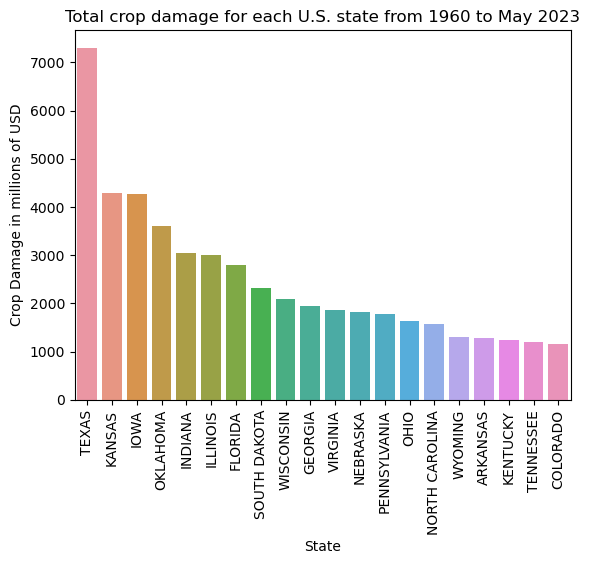

In [16]:
storm_dmg = storms.groupby('STATE', as_index = False).sum('DAMAGE_CROPS')
storm_dmg = storm_dmg.sort_values('YEAR')
storm_dmg = storm_dmg.rename(columns = {'YEAR' : 'DAMAGE_CROPS'})
storm_dmg = storm_dmg.sort_values('DAMAGE_CROPS', ascending = False)

storm_dmg['DAMAGE_CROPS'] = storm_dmg['DAMAGE_CROPS']/1000

display(storm_dmg.head(20))


sns.barplot(data = storm_dmg.head(20), x = 'STATE', y = 'DAMAGE_CROPS')
plt.title("Total crop damage for each U.S. state from 1960 to May 2023")
plt.xlabel("State")
plt.ylabel("Crop Damage in millions of USD")
plt.xticks(rotation=90)

Again, we see that it appears that Texas is both the state that is most commonly hit by storms and suffers the most crop damage. Texas is again followed by midwestern and southern states including Kansas, Iowa, Oklahoma, and Indiana. 


## Hypothesis Testing and ML

Now we will build a model to try to predict the TFP of a state for a year given the data we have. To do this, we will need to build a model using statsmodel. First, we will have to merge our data into one dataframe.

In [22]:
temp_state = temp[['year', 'temp', 'CTYNAME', 'STNAME']]
temp_state = temp_state.groupby(['year','STNAME'], ).mean('temp')
display(temp_state.head())

temp
year STNAME               
1960 Alabama     61.300249
     Arizona     60.922778
     Arkansas    58.837111
     California  56.859339
     Colorado    43.508724